# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams['figure.dpi'] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pysra.motion.SourceTheoryRvtMotion(5.0, 30, 'wna'),
    pysra.motion.SourceTheoryRvtMotion(6.0, 30, 'wna'),
    pysra.motion.SourceTheoryRvtMotion(7.0, 30, 'wna'),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=100), 10, 400),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=200), 10, 450),
    pysra.site.Layer(
        pysra.site.DarendeliSoilType(
            18., plas_index=0, ocr=1, stress_mean=400), 30, 600),
    pysra.site.Layer(
        pysra.site.SoilType('Rock', 24., None, 0.01), 0, 1200),
])

## Create the site response calculator

In [5]:
calc = pysra.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pysra.variation.ToroThicknessVariation()
var_velocity = pysra.variation.DepthDependToroVelVariation.generic_model(
    'USGS C')
var_soiltypes = pysra.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection([
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs,
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs,
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1),
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0),
        # Damping
        0.05),
    pysra.output.InitialVelProfile(),
])

## Perform the calculation

In [8]:
count = 60
outputs.reset()
for i, p in enumerate(pysra.variation.iter_varied_profiles(
    profile,
    count,
    #var_thickness=var_thickness,
    var_velocity=var_velocity,
    #var_soiltypes=var_soiltypes
)):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f'p{i}', f'm{j}')
        calc(m, p, p.location('outcrop', index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

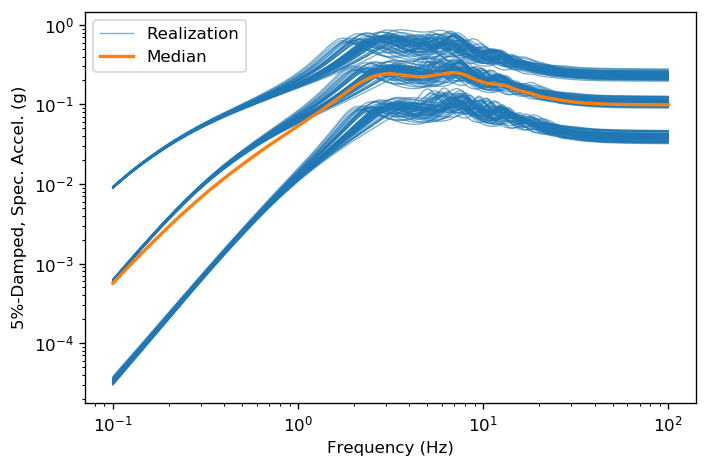

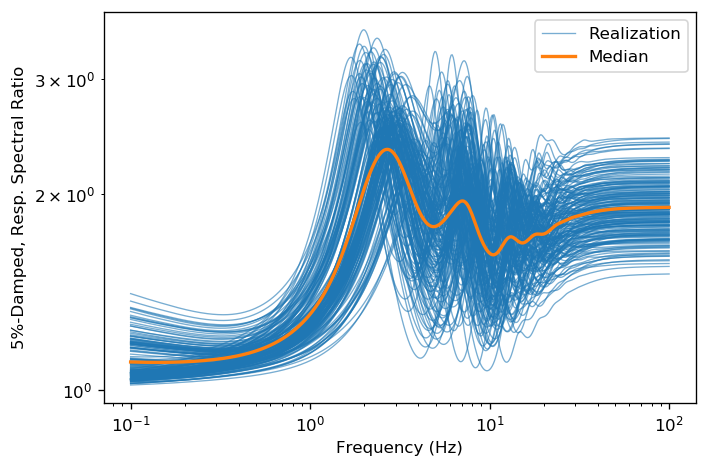

In [9]:
for o in outputs[:-1]:
    ax = o.plot()

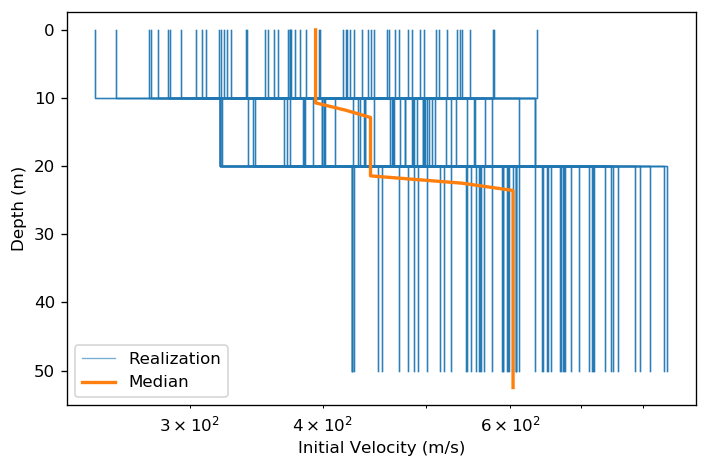

In [10]:
ax = outputs[-1].plot()

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [37]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.254287  1.082707  1.050738  1.201000  1.067598  1.041997   
0.101394    1.253274  1.082627  1.051126  1.200310  1.067549  1.042323   
0.102807    1.252263  1.082553  1.051518  1.199622  1.067504  1.042653   
0.104240    1.251256  1.082485  1.051915  1.198936  1.067464  1.042986   
0.105693    1.250253  1.082423  1.052315  1.198253  1.067430  1.043323   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.707064  1.656349  1.506391  2.035734  1.931373  1.806706   
95.932095   1.707152  1.656442  1.506498  2.035790  1.931427  1.806780   
97.269336   1.707237  1.656533  1.506601  2.035844  1.931478  1.806852   
98.625218   1.707320  1.656620  1.506701  2.035896  1.931528  1.806922   
100.000000  1.707400  1.656705  1.506798  2.035947  1.931577  1.806989   

                  p2                            p3  ...       p56       p57  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.191647  1.065455  1.041507  1.261605  ...  1.041289  1.171007   
0.101394    1.191017  1.065409  1.041829  1.260641  ...  1.041611  1.170449   
0.102807    1.190388  1.065368  1.042154  1.259680  ...  1.041935  1.169892   
0.104240    1.189761  1.065332  1.042483  1.258722  ...  1.042263  1.169337   
0.105693    1.189138  1.065300  1.042815  1.257768  ...  1.042594  1.168784   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.857936  1.792445  1.693104  2.188736  ...  1.697055  1.866474   
95.932095   1.858025  1.792526  1.693205  2.188825  ...  1.697139  1.866527   
97.269336   1.858111  1.792605  1.693303  2.188911  ...  1.697221  1.866578   
98.625218   1.858194  1.792682  1.693398  2.188995  ...  1.697300  1.866628   
100.000000  1.858275  1.792756  1.693490  2.189076  ...  1.697376  1.866676   

                                     p58                           p59  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.057802  1.035672  1.336069  1.107421  1.067318  1.116248   
0.101394    1.057767  1.035953  1.334704  1.107300  1.067813  1.115942   
0.102807    1.057736  1.036238  1.333342  1.107186  1.068313  1.115636   
0.104240    1.057709  1.036525  1.331985  1.107079  1.068819  1.115332   
0.105693    1.057688  1.036815  1.330632  1.106978  1.069330  1.115029   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.789909  1.697603  2.194757  2.051797  1.812084  1.811241   
95.932095   1.789955  1.697665  2.194866  2.051917  1.812228  1.811280   
97.269336   1.790000  1.697725  2.194972  2.052034  1.812368  1.811317   
98.625218   1.790043  1.697783  2.195074  2.052147  1.812503  1.811353   
100.000000  1.790085  1.697839  2.195173  2.052256  1.812634  1.811388   

                                
                  m1        m2  
0.100000    1.039557  1.024211  
0.101394    1.039546  1.024408  
0.102807    1.039539  1.024607  
0.104240    1.039535  1.024808  
0.105693    1.039535  1.025011  
...              ...       ...  
94.613238   1.734083  1.683821  
95.932095   1.734108  1.683859  
97.269336   1.734133  1.683896  
98.625218   1.734158  1.683931  
100.000000  1.734181  1.683966  

[500 rows x 180 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [38]:
# Add names for clarity
df.columns.names = ('profile', 'motion')
df.index.name = 'freq'
# Transform into a long format
df = df.reset_index().melt(id_vars='freq')
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.254287
1,0.101394,p0,m0,1.253274
2,0.102807,p0,m0,1.252263
3,0.104240,p0,m0,1.251256
4,0.105693,p0,m0,1.250253
...,...,...,...,...
89995,94.613238,p59,m2,1.683821
89996,95.932095,p59,m2,1.683859
89997,97.269336,p59,m2,1.683896
89998,98.625218,p59,m2,1.683931


In [39]:
def calc_stats(group):
    ln_value = np.log(group['value'])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({'median': median, 'ln_std': ln_std})

stats = df.groupby(['freq', 'motion']).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.207896  0.053633
           m1      1.069847  0.018742
           m2      1.043783  0.012230
0.101394   m0      1.207181  0.053408
           m1      1.069793  0.018712
...                     ...       ...
98.625218  m1      1.916212  0.087048
           m2      1.788702  0.079288
100.000000 m0      2.018122  0.098561
           m1      1.916271  0.087051
           m2      1.788781  0.079289

[1500 rows x 2 columns]

In [40]:
stats = stats\
    .reset_index('motion')\
    .pivot(columns='motion')\
    .swaplevel(0, 1, axis=1)\
    .sort_index(axis=1)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.053633  1.207896  0.018742  1.069847  0.012230  1.043783
0.101394    0.053408  1.207181  0.018712  1.069793  0.012309  1.044119
0.102807    0.053183  1.206468  0.018683  1.069743  0.012390  1.044458
0.104240    0.052958  1.205758  0.018655  1.069698  0.012471  1.044801
0.105693    0.052733  1.205050  0.018627  1.069659  0.012554  1.045148
...              ...       ...       ...       ...       ...       ...
94.613238   0.098553  2.017862  0.087036  1.916022  0.079282  1.788450
95.932095   0.098555  2.017930  0.087040  1.916087  0.079284  1.788537
97.269336   0.098557  2.017996  0.087044  1.916150  0.079286  1.788621
98.625218   0.098559  2.018060  0.087048  1.916212  0.079288  1.788702
100.000000  0.098561  2.018122  0.087051  1.916271  0.079289  1.788781

[500 rows x 6 columns]

Access the properties of each motion like:

In [41]:
stats['m0']

,ln_std,median
freq,,
0.100000,0.053633,1.207896
0.101394,0.053408,1.207181
0.102807,0.053183,1.206468
0.104240,0.052958,1.205758
0.105693,0.052733,1.205050
...,...,...
94.613238,0.098553,2.017862
95.932095,0.098555,2.017930
97.269336,0.098557,2.017996


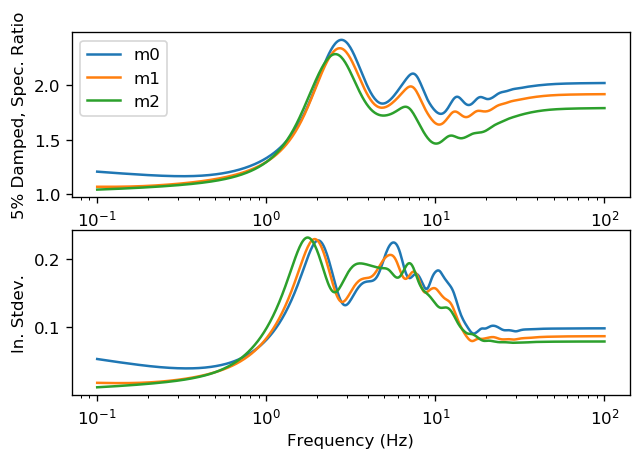

In [43]:
fig, axes = plt.subplots(nrows=2, subplot_kw={'xscale': 'log'})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ['median', 'ln_std']):
        ax.plot(g.index, g[(name, key)], label=name)
        

axes[0].set(ylabel='5% Damped, Spec. Ratio')
axes[0].legend()

axes[1].set(ylabel='ln. Stdev.', xlabel='Frequency (Hz)')

fig;